In [1]:
import sys
from PIL import Image  # pip install Pillow
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
original_file_name = "original.png"
in_file_name = "shuffled.png"
out_file_name = "reconstructed.png"

<h3><center>utils functions</center></h3>

In [3]:
def load_image(file_name):
    img = np.array(Image.open(file_name))
    print("'{}' loaded with shape = {}".format(file_name, img.shape))
    return img

In [4]:
def save_image(img, file_name):
    Image.fromarray(img).save(file_name)

In [5]:
def reconstruct_image(pieces_order, pieces):
    # build columns and them assemble them
    columns = []
    n_cols = pieces_order.shape[1]
    for col in range(n_cols):
        ids_in_col = pieces_order[:, col]
        temp_col = pieces[ids_in_col[0]]
        for idx in ids_in_col[1:]:
            temp_col = np.concatenate((temp_col, pieces[idx]), axis=0)
        columns.append(temp_col)
    res = columns[0]
    for i in range(1, len(columns)):
        res = np.concatenate((res, columns[i]), axis=1)
    return res

In [6]:
def shuffle_image(img, n_cols, n_rows):
    # first generate a list of piece indices. Then build the corresponding image
    row_height = int(img.shape[0] / n_rows)
    col_width = int(img.shape[1] / n_cols)
    rows = [img[row_height*i:row_height*(i+1), :, :] for i in range(n_rows)]

    pieces = []
    for row in rows:
        for col_id in range(n_cols):
            pieces.append(row[:, col_width*col_id:col_width*(col_id+1):, :])

    random_order = list(range(n_cols*n_rows))
    shuffle(random_order)  # equivalent to random.shuffle
    random_order = np.array(random_order).reshape(n_rows, n_cols)
    print("random order = {}".format(random_order))
    print("len(pieces) = {}".format(len(pieces)))
    return reconstruct_image(random_order, pieces)

In [7]:
def plot_costs(costs, threshold):
    fig=plt.figure(figsize=(5, 4), dpi= 80, facecolor='w', edgecolor='k')
    plt.axhline(y=threshold)
    plt.scatter(list(range(len(costs))), costs)
    plt.grid()
    plt.savefig("costs.png")

In [8]:
def smallest_common_diviser(l):
    mini = min(l)
    assert mini > 0
    for i in range(mini, 0, -1):
        rests = [e%i for e in l]
        if not any(rests):
            return i

<h3><center>create or/and load an image</center></h3>

In [9]:
# create a shuffled image
img_original = load_image(original_file_name)
n_cols_wanted = 2
n_rows_wanted = 3
shuffle_img = shuffle_image(img_original, n_cols_wanted, n_rows_wanted)
save_image(shuffle_img, "shuffled.png")

'original.png' loaded with shape = (536, 1061, 4)
random order = [[0 1]
 [4 2]
 [3 5]]
len(pieces) = 6


In [10]:
# read shuffled image
img_in = load_image(in_file_name)

'shuffled.png' loaded with shape = (534, 1060, 4)


original image


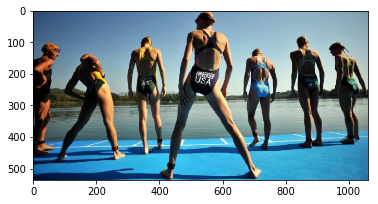

In [11]:
print("original image")
image = plt.imread(original_file_name)
plt.imshow(image)

shuffled image


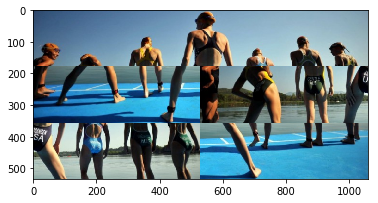

In [12]:
print("shuffled image")
image = plt.imread(in_file_name)
plt.imshow(img_in)

<h3><center>solving functions</center></h3>

In [13]:
def compute_lr_border_cost(s1, s2):
    # compute a fitness score between the right part of s1 and the left part of s2
    r_col = s1[:, -1, :].astype(np.int16)
    l_col = s2[:, 0, :].astype(np.int16)
    diff_col = np.absolute(np.subtract(r_col, l_col))
    return np.sum(diff_col)

In [14]:
def find_n_cols(img, threshold):
    # assuming a constant column width
    costs = []
    ids = []
    print("width = img.shape[1] = {}".format(img.shape[1]))
    for i in range(img.shape[1]-1):
        l = img[:, i:i+1, :]
        r = img[:, i+1:i+2, :]
        cost = compute_lr_border_cost(l, r)
        costs.append(cost)
    for i, c in enumerate(costs):
        if c > threshold:
            ids.append(i)
    print("{} transitions above threshold={} @ pixel {}".format(len(ids), threshold, ids))
    plot_costs(costs, threshold)
    if len(ids) == 0:
        return 1
    if len(ids) == 1:
        col_width = min(img.shape[1] - ids[0], ids[0])
        print(img.shape[1] / col_width)
        res = round(img.shape[1] / col_width)
        return res
    gaps = [ids[i+1]-ids[i] for i in range(len(ids)-1)]   
    print("gaps = {}".format(gaps))
    col_width = smallest_common_diviser(gaps)
    res = int(img.shape[1] / col_width)
    return res

In [15]:
def find_n_rows(img, threshold):
    copy_img = np.copy(img)
    rot_img = np.copy(np.rot90(copy_img))
    return find_n_cols(rot_img, threshold)

In [16]:
def find_first_piece(lr_costs_matrix, ud_costs_matrix):
    # which one to go at the top-left corner
    lr_scores = np.min(lr_costs_matrix, axis=0)
    ud_scores = np.min(ud_costs_matrix, axis=0)
    tot_scores = lr_scores + ud_scores
    id_top_right_corner = np.argmax(tot_scores)
    return id_top_right_corner

In [17]:
class Solver:
    # lr = left-right
    # td = top-down
    def __init__(self, lr_costs_matrix, td_costs_matrix, n_cols, n_rows, first_piece):
        self.lr_cost_matrix = np.copy(lr_costs_matrix)
        self.td_cost_matrix = np.copy(td_costs_matrix)
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.first_piece = first_piece
        self.used_ids = []
        self.res_in_levels = []
    
    def get_idx(self, level, row):
        assert level >= row
        col = level - row
        idx = row * self.n_cols + col
        return idx

    def get_idx_parents(self, level, row):
        # parents have level-1
        # parent_l has col-1 and same row
        # parent_t has same col and row-1
        if level == 0:
            return None, None
        parents_level = level - 1
        if row == level:  # child is on left-most column 
            return None, self.get_idx(parents_level, row-1)
        if row == 0:  # child is on top-most column
            return self.get_idx(parents_level, 0), None
        parent_l_row = row
        parent_t_row = row - 1
        parent_l = self.get_idx(parents_level, parent_l_row)
        parent_t = self.get_idx(parents_level, parent_t_row)
        return parent_l, parent_t
    
    def find_best(self, parent_l, parent_t):
        r_candidates = self.lr_cost_matrix[parent_l, :] if parent_l is not None else 0
        d_candidates = self.td_cost_matrix[parent_t, :] if parent_t is not None else 0
        total_candidates = r_candidates + d_candidates
        found = False
        while not found:
            if np.min(total_candidates) == np.inf:
                print("ERROR: no piece found after self.res_in_levels = [{}]".format(self.res_in_levels))
                return None
            best = np.argmin(total_candidates)
            if best in self.used_ids:
                print("ISSUE: want to add {} a second time as child of parent_l = {} and parent_t = {}".format(best, parent_l, parent_t))
                total_candidates[best] = np.inf
            else:
                found = True
                self.used_ids.append(best)
        return best
    
    def format_res_levels(self, res_in_levels):
        res = np.zeros((self.n_rows, self.n_cols))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                level = row + col
                res[row, col] = res_in_levels[level][row]
        print("res_in_levels = {}".format(res_in_levels))
        print("format_levels = {}".format(res))
        return res.astype(np.int16)

    def get_id_in_res(self, position_in_flat_list, res_in_levels):
        row = position_in_flat_list // self.n_cols
        col = position_in_flat_list % self.n_cols
        level = row + col
        piece_at_position = res_in_levels[level][row]
        return piece_at_position
    
    def solve(self):
        self.lr_cost_matrix[:, self.first_piece] = np.inf  # first piece cannot be a right-neighbour
        self.td_cost_matrix[:, self.first_piece] = np.inf  # first piece cannot be a down-neighbour
        self.used_ids.append(self.first_piece)
        self.res_in_levels = [[first_piece]]  # alone in level=0
        
        for level in range(1, self.n_cols + self.n_rows - 1):
            list_for_level = []
            for row_id in range(min(self.n_rows, level+1)):  # no need to explore row > n_rows
                if level + 1 - row_id > self.n_cols:
                    list_for_level.append(None)
                else:
                    # position of the parents in the 0, 1, 2 ... coordinate system
                    parent_l_out, parent_t_out = self.get_idx_parents(level, row_id)
                    parent_l_in = self.get_id_in_res(parent_l_out, self.res_in_levels) if parent_l_out is not None else None
                    parent_t_in = self.get_id_in_res(parent_t_out, self.res_in_levels) if parent_t_out is not None else None
                    best = self.find_best(parent_l_in, parent_t_in)
                    list_for_level.append(best)
            self.res_in_levels.append(list_for_level)
        res = self.format_res_levels(self.res_in_levels)
        return res

<h3><center>extract pieces</center></h3>

width = img.shape[1] = 1060
1 transitions above threshold=40000 @ pixel [529]
2.003780718336484
2 = n_cols
530 = col_width


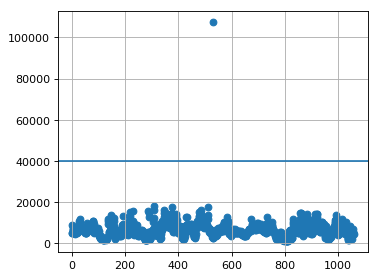

In [18]:
# get number of columns
n_cols = find_n_cols(img_in, threshold=40000)  # play with threshold=... 
col_width = int(img_in.shape[1] / n_cols)
print("{} = n_cols".format(n_cols))
print("{} = col_width".format(col_width))

width = img.shape[1] = 534
2 transitions above threshold=120000 @ pixel [177, 355]
gaps = [178]
3 = n_rows
178 = row_height


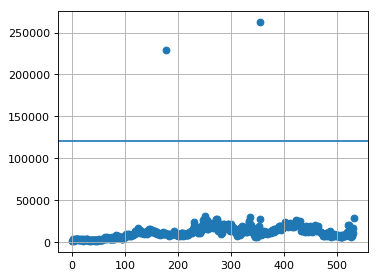

In [19]:
# get number of rows
n_rows = find_n_rows(img_in, threshold=120000)  # play with threshold=... 
row_height = int(img_in.shape[0] / n_rows)
print("{} = n_rows".format(n_rows))
print("{} = row_height".format(row_height))

In [20]:
# create pieces
rows = [img_in[row_height*i:row_height*(i+1), :, :] for i in range(n_rows)]
print(len(rows))
pieces = []
for row in rows:
    for id_col in range(n_cols):
        pieces.append(row[:, col_width*id_col:col_width*(id_col+1), :])
print(len(pieces))
print(pieces[-1].shape)
#plt.imshow(pieces[3])

3
6
(178, 530, 4)


<h3><center>compute best order</center></h3>

In [21]:
# compute fitness score for each neighbouring combination
n_pieces = n_cols*n_rows
lr_border_costs = np.zeros((n_pieces, n_pieces))
td_border_costs = np.zeros((n_pieces, n_pieces))
for p1 in range(n_pieces):
    for p2 in range(n_pieces):
        lr_border_costs[p1][p2] = np.inf if p1==p2 else compute_lr_border_cost(pieces[p1], pieces[p2])
        td_border_costs[p1][p2] = np.inf if p1==p2 else compute_lr_border_cost(np.rot90(pieces[p1]), np.rot90(pieces[p2]))
print(lr_border_costs)
print(td_border_costs)

[[   inf  1467. 28315. 25016. 62733. 57700.]
 [45509.    inf 73704. 82855. 37134. 28435.]
 [34848. 58123.    inf 69066. 48995.   390.]
 [42488. 62795. 50827.    inf  3805. 49490.]
 [47865. 67646. 65924. 75061.    inf 37081.]
 [25683. 48370. 48944. 58831. 42906.    inf]]
[[    inf 112473. 106524.   4948. 122299. 102420.]
 [131243.     inf 120963. 122579.   4198. 112441.]
 [ 86121. 153084.     inf 142131. 165076. 149533.]
 [ 72421.  99388.   4389.     inf 121346.  97893.]
 [100425.  79554.  99831. 102359.     inf   4441.]
 [ 58122.  63321. 103644. 120500. 137271.     inf]]


first_piece = 0
top-left piece:


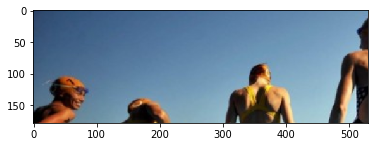

In [22]:
# find first piece (top-left corner)
first_piece = find_first_piece(lr_border_costs, td_border_costs)
print("first_piece = {}".format(first_piece))
print("top-left piece:")
plt.imshow(pieces[first_piece])

In [23]:
# find best order starting from first_piece
solver = Solver(lr_border_costs, td_border_costs, n_cols, n_rows, first_piece)

In [24]:
good_order = solver.solve()
print(good_order)

res_in_levels = [[0], [1, 3], [None, 4, 2], [None, None, 5]]
format_levels = [[0. 1.]
 [3. 4.]
 [2. 5.]]
[[0 1]
 [3 4]
 [2 5]]


In [25]:
reconstructed_img = reconstruct_image(good_order, pieces)

In [26]:
save_image(reconstructed_img, out_file_name)

reconstructed image


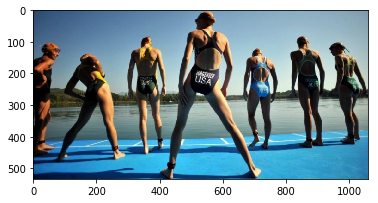

In [27]:
print("reconstructed image")
image = plt.imread(out_file_name)
plt.imshow(image)

<h4><center>draft</center></h4>

In [28]:
# important to define a signed type for subtractions
a = np.arange(9, dtype=np.uint8).reshape(3,3)
b = a+a
print(a-b)

[[  0 255 254]
 [253 252 251]
 [250 249 248]]


In [29]:
a = a.astype(np.int16)
b = b.astype(np.int16)
print(a-b)

[[ 0 -1 -2]
 [-3 -4 -5]
 [-6 -7 -8]]
